#First Try with the Sequential API from Tensorflow

In [ ]:
import tensorflow as tf
import numpy as np
import random as rd
import time

from matplotlib import pyplot as plt
from tensorflow import keras
from tensorflow.keras.datasets import mnist
from scipy.ndimage import rotate, gaussian_filter
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

#GPU Config

In [ ]:
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices)!=0: #Use GPU for better experience
  tf.config.experimental.set_memory_growth(physical_devices[0],True)
print(physical_devices)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


#Load Data from the mnist dataset

In [ ]:
(x_train,y_train), (x_test,y_test) = mnist.load_data()
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(60000, 28, 28)
(10000, 28, 28)
(60000,)
(10000,)


#Plot some image in the dataset

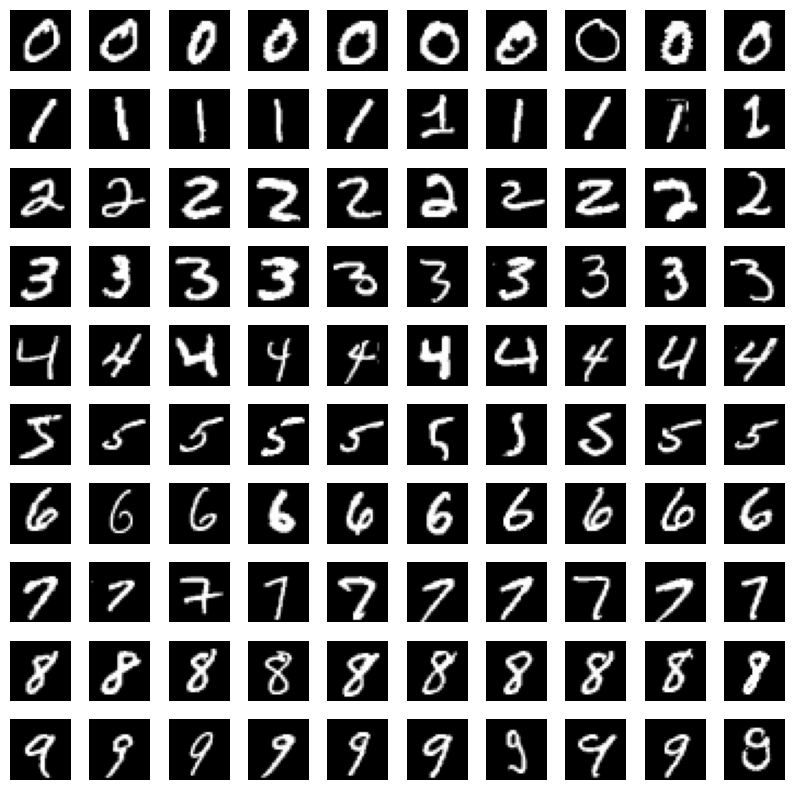

In [ ]:
fig, axes = plt.subplots(10, 10, figsize=(10, 10))
fig.subplots_adjust(hspace=0.3, wspace=0.3)

for label in range(10):
    indices = np.where(y_train == label)[0][:10]
    for i, idx in enumerate(indices):
        ax = axes[label, i]
        ax.imshow(x_train[idx], cmap='gray')
        ax.axis('off')

plt.show()

##As shown, those images are quite well organised, so they will have to be augmented so that the NN cant just recall

#Plot the label distribution of the dataset

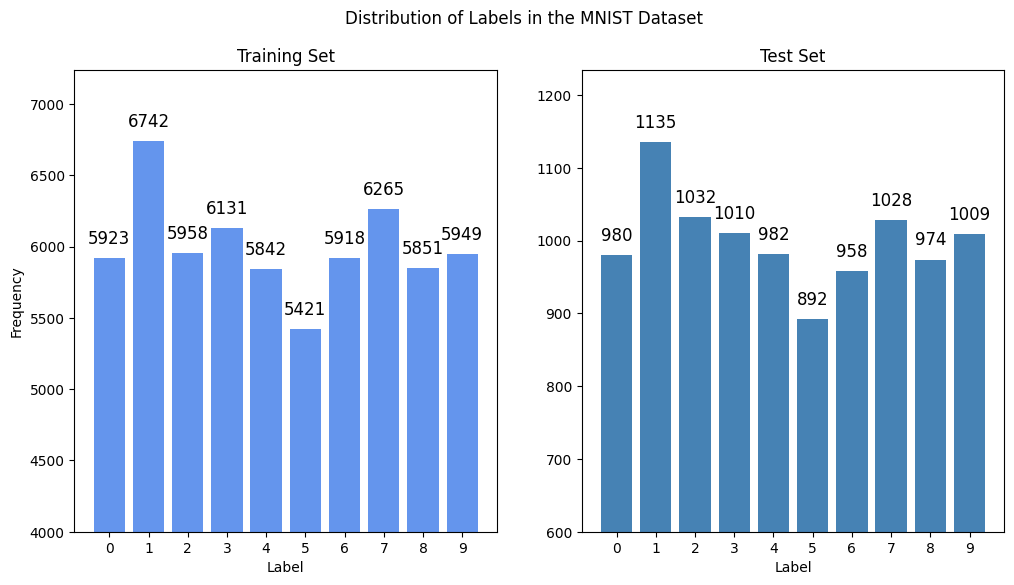

In [ ]:
train_label_counts = np.bincount(y_train, minlength=10)
test_label_counts = np.bincount(y_test, minlength=10)

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
fig.suptitle('Distribution of Labels in the MNIST Dataset')

ax[0].bar(range(10), train_label_counts, color='cornflowerblue')
ax[0].set_xlabel('Label')
ax[0].set_ylabel('Frequency')
ax[0].set_title('Training Set')
ax[0].set_xticks(range(10))
ax[0].set_ylim(4000, max(train_label_counts) + 500)
for i, count in enumerate(train_label_counts):
    ax[0].text(i, count + 100, str(count), ha='center', color='black', fontsize=12)

ax[1].bar(range(10), test_label_counts, color='steelblue')
ax[1].set_xlabel('Label')
ax[1].set_title('Test Set')
ax[1].set_xticks(range(10))
ax[1].set_ylim(600, max(test_label_counts) + 100)
for i, count in enumerate(test_label_counts):
    ax[1].text(i, count + 20, str(count), ha='center', color='black', fontsize=12)

plt.show()

#Preprocessing Data

##Normalization

In [ ]:
x_train = x_train.astype('float32')/255.0
x_test = x_test.astype('float32')/255.0

In [ ]:
print(x_train.shape)
print(type(x_train))
print(max(x_train.flatten()),min(x_train.flatten()))
print(x_test.shape)
print(type(x_test))
print(max(x_test.flatten()),min(x_test.flatten()))

(60000, 28, 28)
<class 'numpy.ndarray'>
1.0 0.0
(10000, 28, 28)
<class 'numpy.ndarray'>
1.0 0.0


##Augmentation

In [ ]:
from scipy.ndimage import rotate, gaussian_filter

#Rotation 30 deg maximum, just to make sure the labels wont mess up such as 9 and 6 or 2 and 5 or even 1 and 7
def random_rotate_image_2d(image, max_angle=30):
    angle = np.random.uniform(-max_angle, max_angle)
    rotated_image = rotate(image, angle, reshape=False, mode='nearest')
    return rotated_image

#Shift images horizontaly or vertically a few pixels
def shift_image(image, max_offset=3):
    offset_x = np.random.randint(-max_offset, max_offset + 1)
    offset_y = np.random.randint(-max_offset, max_offset + 1)
    return np.roll(np.roll(image.reshape(28, 28), offset_x, axis=1), offset_y, axis=0)

#Add gaussian noise
def add_gaussian_noise(image, mean=0,std=0.1):
    noise = np.random.normal(mean, std, image.shape)
    return np.clip(image + noise, 0, 1) #Remember to use with the normalized image pumpkin

def reduce_noise(image, sigma=0.5):
  return gaussian_filter(image, sigma=sigma)

def augment(image):
  image = random_rotate_image_2d(image)
  image = shift_image(image)
  image = add_gaussian_noise(image)
  image = reduce_noise(image)
  return image

###Some example of the augmented image

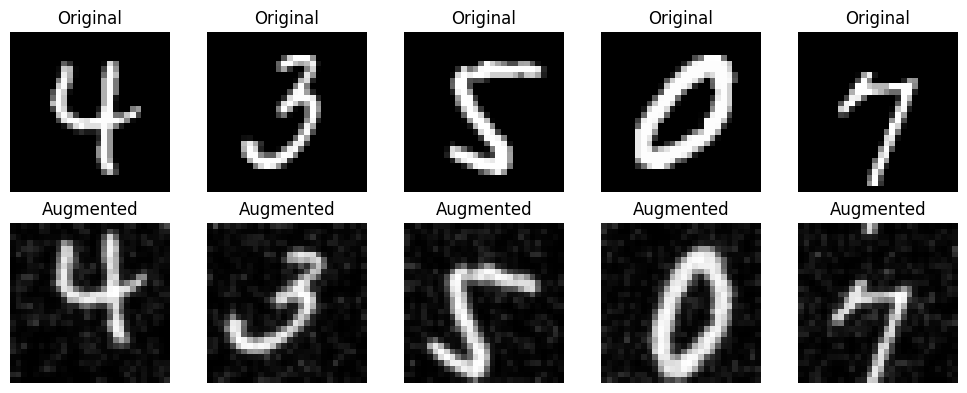

In [ ]:
num_images = 5

plt.figure(figsize=(10, 4))

for i in range(num_images):
    idx = np.random.randint(0, x_train.shape[0])
    original_image = x_train[idx]
    augmented_image = augment(original_image)

    plt.subplot(2, num_images, i + 1)
    plt.imshow(original_image, cmap='gray')
    plt.axis('off')
    plt.title("Original")

    plt.subplot(2, num_images, num_images + i + 1)
    plt.imshow(augmented_image, cmap='gray')
    plt.axis('off')
    plt.title("Augmented")

plt.tight_layout()
plt.show()

###Apply augmentation for the whole training set

In [ ]:
x_train = np.array([augment(image) for image in x_train])

###print those previous step after augmentation

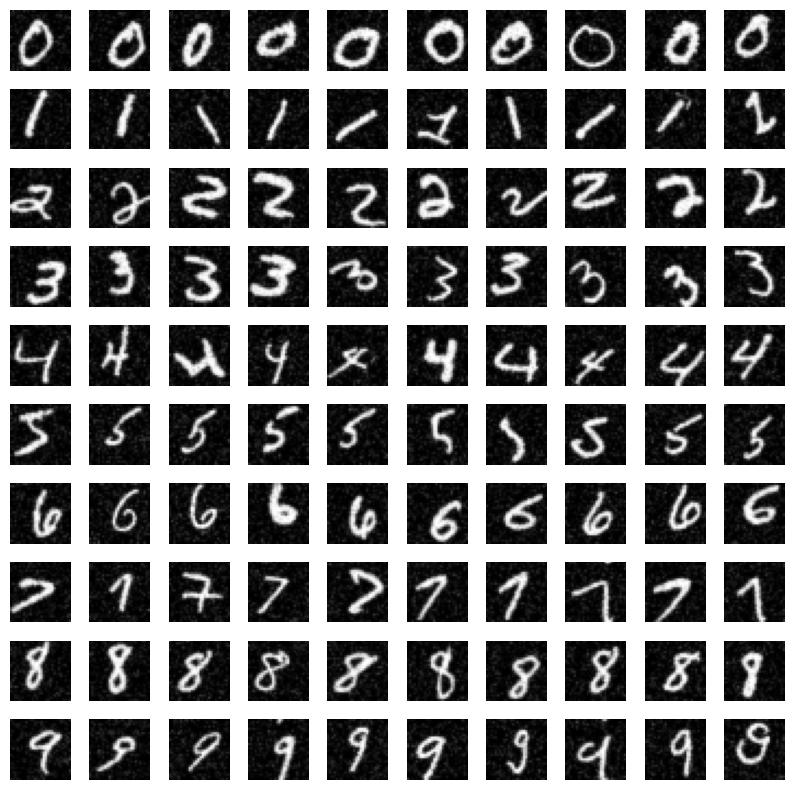

In [ ]:
fig, axes = plt.subplots(10, 10, figsize=(10, 10))
fig.subplots_adjust(hspace=0.3, wspace=0.3)

for label in range(10):
    indices = np.where(y_train == label)[0][:10]
    for i, idx in enumerate(indices):
        ax = axes[label, i]
        ax.imshow(x_train[idx], cmap='gray')
        ax.axis('off')

plt.show()

Much worse, now the NN can confuse the 7 and 1 label, which leads to a decrease in precision

##Flattening

In [ ]:
x_train = x_train.reshape(-1,28*28)
x_test = x_test.reshape(-1,28*28)

In [ ]:
print(x_train.shape)
print(x_test.shape)

(60000, 784)
(10000, 784)


##Split the Dtrain => Dtrain and Tvalid for model assesment and selection

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.2, stratify=y_train)
print(f"Dtrain splitted into 2 subsets: Dtrain : {x_train.shape[0]}, Tvalid: {x_valid.shape[0]}")

Dtrain splitted into 2 subsets: Dtrain : 48000, Tvalid: 12000


##One-hot encode labels

In [ ]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, num_classes=10)
y_valid = to_categorical(y_valid, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

#Sample Model

In [ ]:
model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=(28*28,)),
    layers.Dense(64, activation='relu'),
    layers.Dense(10, activation='softmax')
]);

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(x_train, y_train, epochs=5, batch_size=32, validation_data=(x_valid, y_valid), verbose=2)

model.evaluate(x_test, y_test, verbose=2)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
1500/1500 - 5s - 3ms/step - accuracy: 0.7522 - loss: 0.7735 - val_accuracy: 0.8533 - val_loss: 0.4553
Epoch 2/5
1500/1500 - 2s - 2ms/step - accuracy: 0.8846 - loss: 0.3696 - val_accuracy: 0.8899 - val_loss: 0.3478
Epoch 3/5
1500/1500 - 2s - 2ms/step - accuracy: 0.9142 - loss: 0.2819 - val_accuracy: 0.9010 - val_loss: 0.3208
Epoch 4/5
1500/1500 - 2s - 2ms/step - accuracy: 0.9287 - loss: 0.2289 - val_accuracy: 0.8987 - val_loss: 0.3314
Epoch 5/5
1500/1500 - 2s - 2ms/step - accuracy: 0.9383 - loss: 0.1927 - val_accuracy: 0.9036 - val_loss: 0.3196
313/313 - 1s - 4ms/step - accuracy: 0.9243 - loss: 0.2710


[0.2710499167442322, 0.9243000149726868]

#Chosing best function with sample model and grid search for highest validation accuracy model

#This donut takes about 1 hr, just get the result behind

In [ ]:
func_grid = {
  'activation': ['relu', 'leaky_relu'],
  'optimizer': ['sgd', 'momentum', 'adam'],
  'loss': ['categorical_crossentropy', 'hinge', 'mse', 'mae'],
}

record = {
  'activation': '',
  'optimizer': '',
  'loss': '',
  'valid_accuracy': 0.0
}

for activation in func_grid['activation']:
  for optimizer_name in func_grid['optimizer']:
    for loss in func_grid['loss']:
      print(f"Activation: {activation}, Optimizer: {optimizer_name}, Loss: {loss}")
      if optimizer_name == 'momentum':
        optimizer = keras.optimizers.SGD(learning_rate=0.1, momentum=0.9)
      else:
        optimizer = optimizer_name
      model = keras.Sequential([
        layers.Dense(128, activation=activation),
        layers.Dense(64, activation=activation),
        layers.Dense(10, activation='softmax')
      ])
      model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
      result = model.fit(x_train, y_train, epochs=50, batch_size=32, validation_data=(x_valid, y_valid), verbose = 0)
      accuracy = result.history['val_accuracy'][-1]
      print(f"Validation Accuracy: {accuracy}")
      if accuracy > record['valid_accuracy']:
        record['activation'] = activation
        record['optimizer'] = optimizer_name
        record['loss'] = loss
        record['valid_accuracy'] = accuracy
        record['history'] = result

Activation: relu, Optimizer: sgd, Loss: categorical_crossentropy
Validation Accuracy: 0.9167500138282776
Activation: relu, Optimizer: sgd, Loss: hinge
Validation Accuracy: 0.4321666657924652
Activation: relu, Optimizer: sgd, Loss: mse
Validation Accuracy: 0.6834166646003723
Activation: relu, Optimizer: sgd, Loss: mae
Validation Accuracy: 0.4833333194255829
Activation: relu, Optimizer: momentum, Loss: categorical_crossentropy
Validation Accuracy: 0.7397500276565552
Activation: relu, Optimizer: momentum, Loss: hinge
Validation Accuracy: 0.7637500166893005
Activation: relu, Optimizer: momentum, Loss: mse
Validation Accuracy: 0.9265000224113464
Activation: relu, Optimizer: momentum, Loss: mae
Validation Accuracy: 0.7592499852180481
Activation: relu, Optimizer: adam, Loss: categorical_crossentropy
Validation Accuracy: 0.9255833625793457
Activation: relu, Optimizer: adam, Loss: hinge
Validation Accuracy: 0.9178333282470703
Activation: relu, Optimizer: adam, Loss: mse
Validation Accuracy: 0.9

##Best function

Best combination relu, momentum, mse, 0.9265000224113464


<Figure size 640x480 with 0 Axes>

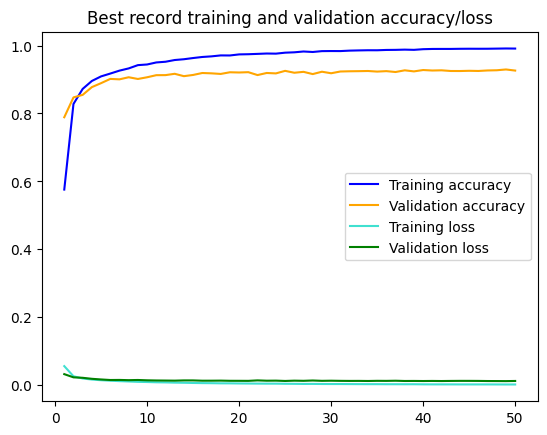

<Figure size 640x480 with 0 Axes>

In [ ]:
print(f"Best combination {record['activation']}, {record['optimizer']}, {record['loss']}, {record['valid_accuracy']}")
train_acc = record['history'].history['accuracy']
validate_acc = record['history'].history['val_accuracy']
train_loss = record['history'].history['loss']
validate_loss = record['history'].history['val_loss']
epochs = range(1, len(train_acc) + 1)
plt.plot(epochs, train_acc, color = 'blue', label='Training accuracy')
plt.plot(epochs, validate_acc, color = 'orange', label='Validation accuracy')
plt.plot(epochs, train_loss, color = 'turquoise', label='Training loss')
plt.plot(epochs, validate_loss, color = 'green', label='Validation loss')
plt.title('Best record training and validation accuracy/loss')
plt.legend()
plt.figure()

So (relu, momentum, mse) is the best for the fcn with 3 hidden layers 128,64,10 but we're using (relu, adam crossentropy) because why not?



##Chossing network structure, starting from 1 hidden layer with random dropout rate, neurons per layer and weight decay, take the average accuracy on the valid set as the criteria. Batch size: 32, 50 epochs

In [ ]:
params_grid = {
  'neurons': [16, 32, 64, 128, 256, 512, 1024],
  'learning_rate' : [1e-2, 1e-3, 1e-4, 1e-5],
  'weight_decay': [0, 1e-2, 1e-3, 1e-4, 1e-5],
  'drop_rate': [0, 0.1, 0.2, 0.3, 0.4, 0.5]
}

In [ ]:
def create_model(neurons, dropout_rate, weight_decay, learning_rate):
  model = Sequential()
  for i in range (len(neurons)):
    model.add(Dense(neurons[i], activation='relu', kernel_regularizer=l2(weight_decay[i])))
    model.add(Dropout(dropout_rate[i]))
  model.add(Dense(10, activation='softmax'))
  model.compile(optimizer=Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])
  return model

def start(hidden_layer):
  scores = []
  train_times = []
  for i in range (30):
    config = {
      'neurons': sorted([rd.choice(params_grid['neurons']) for ii in range(hidden_layer)], reverse=True),
      'learning_rate': rd.choice(params_grid['learning_rate']),
      'weight_decay': [rd.choice(params_grid['weight_decay']) for ii in range(hidden_layer)],
      'drop_rate': [rd.choice(params_grid['drop_rate']) for ii in range(hidden_layer)]
    }
    print(config)
    model = create_model(config['neurons'],config['drop_rate'],config['weight_decay'],config['learning_rate'])
    start_time = time.time()
    history = model.fit(x_train, y_train, batch_size=32, epochs=50, validation_data=(x_valid, y_valid), verbose=0)
    end_time = time.time()
    train_times.append(end_time - start_time)
    score = model.evaluate(x_valid, y_valid, verbose=0)
    scores.append(score)
    print(scores[-1])
    print(train_times[-1])
  return scores, train_times

##1 Hidden layer

In [ ]:
res1=start(1)

{'neurons': [16], 'learning_rate': 0.001, 'weight_decay': [0], 'drop_rate': [0.2]}
[0.8261659145355225, 0.7440000176429749]
152.07527661323547
{'neurons': [512], 'learning_rate': 0.01, 'weight_decay': [0], 'drop_rate': [0.5]}
[0.7914613485336304, 0.796999990940094]
746.2274074554443
{'neurons': [32], 'learning_rate': 0.01, 'weight_decay': [0.001], 'drop_rate': [0.5]}
[1.8995543718338013, 0.38091665506362915]
183.58801221847534
{'neurons': [32], 'learning_rate': 1e-05, 'weight_decay': [0.001], 'drop_rate': [0.5]}
[1.4294770956039429, 0.5994166731834412]
181.16678929328918
{'neurons': [32], 'learning_rate': 0.0001, 'weight_decay': [0], 'drop_rate': [0]}
[0.5231529474258423, 0.8377500176429749]
176.4418363571167
{'neurons': [64], 'learning_rate': 0.001, 'weight_decay': [1e-05], 'drop_rate': [0.3]}
[0.44885221123695374, 0.8789166808128357]
217.04055285453796
{'neurons': [16], 'learning_rate': 0.01, 'weight_decay': [0.0001], 'drop_rate': [0.1]}
[2.038140058517456, 0.23541666567325592]
165.1

In [ ]:
print(res1)

([[0.8261659145355225, 0.7440000176429749], [0.7914613485336304, 0.796999990940094], [1.8995543718338013, 0.38091665506362915], [1.4294770956039429, 0.5994166731834412], [0.5231529474258423, 0.8377500176429749], [0.44885221123695374, 0.8789166808128357], [2.038140058517456, 0.23541666567325592], [1.6534630060195923, 0.5057500004768372], [0.8452709913253784, 0.7681666612625122], [0.756557285785675, 0.7872499823570251], [1.0614041090011597, 0.6993333101272583], [0.7142887115478516, 0.8012499809265137], [0.6940672397613525, 0.8072500228881836], [0.2676893174648285, 0.9381666779518127], [0.35926932096481323, 0.9014999866485596], [1.5269396305084229, 0.5887500047683716], [1.5095922946929932, 0.5134999752044678], [0.38329389691352844, 0.8927500247955322], [1.326414704322815, 0.5690833330154419], [0.605566143989563, 0.8372499942779541], [0.40780818462371826, 0.9294999837875366], [0.5804935097694397, 0.8627499938011169], [1.2263472080230713, 0.6475833058357239], [1.4112629890441895, 0.54891663

##2 Hidden layer

In [ ]:
res2=start(2)

{'neurons': [256, 256], 'learning_rate': 1e-05, 'weight_decay': [0.001, 0.01], 'drop_rate': [0, 0.2]}
[0.8028948307037354, 0.8794999718666077]
454.64668440818787
{'neurons': [64, 16], 'learning_rate': 0.01, 'weight_decay': [0.01, 0.001], 'drop_rate': [0.5, 0.4]}
[2.261995553970337, 0.19841666519641876]
227.21921849250793
{'neurons': [128, 32], 'learning_rate': 0.0001, 'weight_decay': [0.001, 1e-05], 'drop_rate': [0.2, 0.1]}
[0.33886370062828064, 0.921833336353302]
328.7646994590759
{'neurons': [256, 32], 'learning_rate': 0.01, 'weight_decay': [0.0001, 0.001], 'drop_rate': [0, 0.4]}
[2.302537441253662, 0.10441666841506958]
476.292279958725
{'neurons': [1024, 16], 'learning_rate': 1e-05, 'weight_decay': [0.0001, 0.001], 'drop_rate': [0.5, 0.2]}
[0.6010971665382385, 0.8820833563804626]
1013.0335381031036
{'neurons': [256, 16], 'learning_rate': 1e-05, 'weight_decay': [1e-05, 0.001], 'drop_rate': [0, 0.1]}
[0.5904258489608765, 0.8520833253860474]
460.0291919708252
{'neurons': [64, 64], 'lea

In [ ]:
print(res2)

([[0.8028948307037354, 0.8794999718666077], [2.261995553970337, 0.19841666519641876], [0.33886370062828064, 0.921833336353302], [2.302537441253662, 0.10441666841506958], [0.6010971665382385, 0.8820833563804626], [0.5904258489608765, 0.8520833253860474], [0.45592355728149414, 0.890916645526886], [1.7470875978469849, 0.4517500102519989], [0.3356975317001343, 0.9120833277702332], [0.4139208495616913, 0.909166693687439], [2.302487373352051, 0.10441666841506958], [0.9699339866638184, 0.7894999980926514], [0.8633177876472473, 0.7959166765213013], [0.2866082489490509, 0.9460833072662354], [0.36564376950263977, 0.8943333625793457], [1.4207780361175537, 0.6101666688919067], [0.9817715883255005, 0.7701666951179504], [0.430400013923645, 0.9107499718666077], [0.38132405281066895, 0.9415833353996277], [0.9448499083518982, 0.7799999713897705], [0.7090449333190918, 0.8228333592414856], [0.8351338505744934, 0.8669999837875366], [0.32508790493011475, 0.9385833144187927], [0.46479305624961853, 0.9283333

##3 Hidden layer

In [ ]:
res3=start(3)

{'neurons': [1024, 512, 128], 'learning_rate': 0.001, 'weight_decay': [0.001, 0, 0.01], 'drop_rate': [0.3, 0.3, 0.5]}
[0.6513423323631287, 0.921583354473114]
3237.267301797867
{'neurons': [512, 256, 32], 'learning_rate': 1e-05, 'weight_decay': [0.01, 0.01, 0.01], 'drop_rate': [0, 0.3, 0.1]}
[1.1618343591690063, 0.8504999876022339]
1020.6715955734253
{'neurons': [1024, 128, 16], 'learning_rate': 0.0001, 'weight_decay': [0.0001, 0.0001, 0.001], 'drop_rate': [0.4, 0.2, 0.5]}
[0.3676528036594391, 0.9425833225250244]
1899.5836851596832
{'neurons': [32, 16, 16], 'learning_rate': 0.001, 'weight_decay': [0, 0, 0.001], 'drop_rate': [0.2, 0, 0]}
[0.5383782982826233, 0.8316666483879089]
259.49037408828735
{'neurons': [1024, 256, 256], 'learning_rate': 1e-05, 'weight_decay': [0.001, 0, 1e-05], 'drop_rate': [0.2, 0, 0.4]}
[0.5107294321060181, 0.9310833215713501]
1851.320111989975
{'neurons': [32, 16, 16], 'learning_rate': 0.001, 'weight_decay': [0.001, 0.0001, 0.001], 'drop_rate': [0, 0.3, 0.2]}
[0

In [ ]:
print(res3)

([[0.6513423323631287, 0.921583354473114], [1.1618343591690063, 0.8504999876022339], [0.3676528036594391, 0.9425833225250244], [0.5383782982826233, 0.8316666483879089], [0.5107294321060181, 0.9310833215713501], [0.6862637400627136, 0.8234166502952576], [0.5841405987739563, 0.9295833110809326], [0.36433470249176025, 0.9010833501815796], [0.38864558935165405, 0.9225000143051147], [0.43133342266082764, 0.9150833487510681], [0.5280541777610779, 0.9100833535194397], [0.4437328279018402, 0.918916642665863], [0.39485591650009155, 0.8804166913032532], [2.303407669067383, 0.11233333498239517], [0.785591721534729, 0.8943333625793457], [0.7789145708084106, 0.8890833258628845], [1.8003957271575928, 0.44208332896232605], [0.3219013810157776, 0.9422500133514404], [0.829504132270813, 0.8205833435058594], [0.9909481406211853, 0.7404166460037231], [0.46015504002571106, 0.890999972820282], [0.3979155719280243, 0.9309166669845581], [0.6141761541366577, 0.8333333134651184], [0.3339128792285919, 0.93916666

##4 Hidden layer

In [ ]:
res4=start(4)

{'neurons': [512, 32, 16, 16], 'learning_rate': 0.01, 'weight_decay': [0, 0.01, 0.0001, 1e-05], 'drop_rate': [0.2, 0.3, 0.3, 0.4]}
[2.3019165992736816, 0.11233333498239517]
986.9432902336121
{'neurons': [1024, 1024, 256, 16], 'learning_rate': 0.01, 'weight_decay': [0.01, 0.01, 0, 0.001], 'drop_rate': [0.3, 0.2, 0.1, 0.4]}
[2.302335023880005, 0.09749999642372131]
3938.63822722435
{'neurons': [1024, 128, 64, 32], 'learning_rate': 0.0001, 'weight_decay': [1e-05, 0.001, 1e-05, 0.001], 'drop_rate': [0.2, 0.3, 0.3, 0.5]}
[0.3661690652370453, 0.9435833096504211]
1870.3833079338074
{'neurons': [1024, 256, 64, 32], 'learning_rate': 0.0001, 'weight_decay': [0, 0.01, 0.01, 0.001], 'drop_rate': [0.5, 0.1, 0.1, 0.4]}
[0.3751339614391327, 0.9369999766349792]
1972.574006319046
{'neurons': [256, 256, 32, 32], 'learning_rate': 0.01, 'weight_decay': [1e-05, 0, 0.0001, 1e-05], 'drop_rate': [0.4, 0.4, 0.4, 0]}
[2.3014283180236816, 0.11233333498239517]
908.7980568408966
{'neurons': [1024, 128, 64, 32], 'le

In [ ]:
print(res4)

NameError: name 'res4' is not defined

In [ ]:
res5=start(5)

{'neurons': [1024, 256, 128, 64, 64], 'learning_rate': 1e-05, 'weight_decay': [1e-05, 0.0001, 0.0001, 0.001, 0.001], 'drop_rate': [0.4, 0.2, 0.4, 0.5, 0.2]}
[0.5364149808883667, 0.8979166746139526]
1858.371815443039
{'neurons': [128, 64, 64, 32, 16], 'learning_rate': 1e-05, 'weight_decay': [1e-05, 0.0001, 0.001, 0.01, 0.0001], 'drop_rate': [0.5, 0.5, 0.2, 0.4, 0.5]}
[1.8577057123184204, 0.3620833456516266]
425.9579391479492
{'neurons': [512, 64, 32, 16, 16], 'learning_rate': 0.001, 'weight_decay': [0.01, 0.001, 0.001, 0.0001, 0.001], 'drop_rate': [0, 0.4, 0.2, 0.3, 0.4]}
[1.1831907033920288, 0.690666675567627]
930.8481359481812
{'neurons': [512, 128, 128, 128, 64], 'learning_rate': 0.0001, 'weight_decay': [0.0001, 0, 0.0001, 0.001, 0.01], 'drop_rate': [0.5, 0, 0.4, 0.5, 0.5]}
[0.34458422660827637, 0.9392499923706055]
967.7578518390656
{'neurons': [1024, 512, 128, 16, 16], 'learning_rate': 1e-05, 'weight_decay': [1e-05, 0.0001, 0.0001, 1e-05, 1e-05], 'drop_rate': [0.5, 0.4, 0.2, 0, 0.1]

In [ ]:
print(res5)

##Plot some graphs

In [ ]:
import numpy as np
g1 = ([[0.8261659145355225, 0.7440000176429749], [0.7914613485336304, 0.796999990940094], [1.8995543718338013, 0.38091665506362915], [1.4294770956039429, 0.5994166731834412], [0.5231529474258423, 0.8377500176429749], [0.44885221123695374, 0.8789166808128357], [2.038140058517456, 0.23541666567325592], [1.6534630060195923, 0.5057500004768372], [0.8452709913253784, 0.7681666612625122], [0.756557285785675, 0.7872499823570251], [1.0614041090011597, 0.6993333101272583], [0.7142887115478516, 0.8012499809265137], [0.6940672397613525, 0.8072500228881836], [0.2676893174648285, 0.9381666779518127], [0.35926932096481323, 0.9014999866485596], [1.5269396305084229, 0.5887500047683716], [1.5095922946929932, 0.5134999752044678], [0.38329389691352844, 0.8927500247955322], [1.326414704322815, 0.5690833330154419], [0.605566143989563, 0.8372499942779541], [0.40780818462371826, 0.9294999837875366], [0.5804935097694397, 0.8627499938011169], [1.2263472080230713, 0.6475833058357239], [1.4112629890441895, 0.5489166378974915], [1.7038005590438843, 0.4517500102519989], [0.7178336381912231, 0.8119999766349792], [1.4256243705749512, 0.6134166717529297], [1.4471616744995117, 0.5294166803359985], [0.5919173359870911, 0.9246666431427002], [0.9307528734207153, 0.7315833568572998]], [152.07527661323547, 746.2274074554443, 183.58801221847534, 181.16678929328918, 176.4418363571167, 217.04055285453796, 165.16004419326782, 1035.2588350772858, 177.01060247421265, 175.95072770118713, 209.87580752372742, 178.44012665748596, 300.2020652294159, 1137.0548372268677, 1007.3160376548767, 181.38310360908508, 170.48978233337402, 1010.2833268642426, 162.12099981307983, 183.99855875968933, 484.39645886421204, 766.7926127910614, 178.5691077709198, 169.30930376052856, 300.3291029930115, 314.8485634326935, 963.8747899532318, 195.8401894569397, 413.1844267845154, 216.99475121498108])
g2 = ([[0.8028948307037354, 0.8794999718666077], [2.261995553970337, 0.19841666519641876], [0.33886370062828064, 0.921833336353302], [2.302537441253662, 0.10441666841506958], [0.6010971665382385, 0.8820833563804626], [0.5904258489608765, 0.8520833253860474], [0.45592355728149414, 0.890916645526886], [1.7470875978469849, 0.4517500102519989], [0.3356975317001343, 0.9120833277702332], [0.4139208495616913, 0.909166693687439], [2.302487373352051, 0.10441666841506958], [0.9699339866638184, 0.7894999980926514], [0.8633177876472473, 0.7959166765213013], [0.2866082489490509, 0.9460833072662354], [0.36564376950263977, 0.8943333625793457], [1.4207780361175537, 0.6101666688919067], [0.9817715883255005, 0.7701666951179504], [0.430400013923645, 0.9107499718666077], [0.38132405281066895, 0.9415833353996277], [0.9448499083518982, 0.7799999713897705], [0.7090449333190918, 0.8228333592414856], [0.8351338505744934, 0.8669999837875366], [0.32508790493011475, 0.9385833144187927], [0.46479305624961853, 0.9283333420753479], [1.0934500694274902, 0.6583333611488342], [1.8282747268676758, 0.3763333261013031], [0.26909852027893066, 0.9211666584014893], [1.6790205240249634, 0.4515833258628845], [1.7131534814834595, 0.5009999871253967], [0.34068039059638977, 0.921750009059906]], [454.64668440818787, 227.21921849250793, 328.7646994590759, 476.292279958725, 1013.0335381031036, 460.0291919708252, 227.26273322105408, 219.8542869091034, 872.7391605377197, 459.9950306415558, 467.5660631656647, 456.30905628204346, 417.81707406044006, 958.0117461681366, 362.60236144065857, 213.41366267204285, 1816.8880836963654, 475.0864109992981, 1713.9726099967957, 314.32941365242004, 353.982310295105, 462.08443903923035, 1006.9230535030365, 1807.1225497722626, 1004.670163154602, 221.65285181999207, 1854.7310090065002, 329.86846566200256, 202.66874861717224, 1931.6490247249603])
g3 = ([[0.6513423323631287, 0.921583354473114], [1.1618343591690063, 0.8504999876022339], [0.3676528036594391, 0.9425833225250244], [0.5383782982826233, 0.8316666483879089], [0.5107294321060181, 0.9310833215713501], [0.6862637400627136, 0.8234166502952576], [0.5841405987739563, 0.9295833110809326], [0.36433470249176025, 0.9010833501815796], [0.38864558935165405, 0.9225000143051147], [0.43133342266082764, 0.9150833487510681], [0.5280541777610779, 0.9100833535194397], [0.4437328279018402, 0.918916642665863], [0.39485591650009155, 0.8804166913032532], [2.303407669067383, 0.11233333498239517], [0.785591721534729, 0.8943333625793457], [0.7789145708084106, 0.8890833258628845], [1.8003957271575928, 0.44208332896232605], [0.3219013810157776, 0.9422500133514404], [0.829504132270813, 0.8205833435058594], [0.9909481406211853, 0.7404166460037231], [0.46015504002571106, 0.890999972820282], [0.3979155719280243, 0.9309166669845581], [0.6141761541366577, 0.8333333134651184], [0.3339128792285919, 0.9391666650772095], [0.6855551600456238, 0.9100000262260437], [0.6701663136482239, 0.8690833449363708], [0.5991337299346924, 0.9135833382606506], [0.6228006482124329, 0.8369166851043701], [0.5637860298156738, 0.9288333058357239], [0.6045607924461365, 0.921583354473114]], [3237.267301797867, 1020.6715955734253, 1899.5836851596832, 259.49037408828735, 1851.320111989975, 251.00827145576477, 1947.1564030647278, 431.793833732605, 3878.2358767986298, 535.2870445251465, 441.955046415329, 548.1654846668243, 351.4592170715332, 1319.0099906921387, 972.6917765140533, 1008.2621874809265, 442.36866426467896, 1007.9963099956512, 448.84370732307434, 453.9657726287842, 360.22232007980347, 3858.144273519516, 433.65018010139465, 1920.3285746574402, 1937.7113780975342, 331.5235974788666, 1839.5671122074127, 514.7213804721832, 3476.3490245342255, 2280.530478000641])
g4 = ([[2.3019165992736816, 0.11233333498239517], [2.302335023880005, 0.09749999642372131], [0.3661690652370453, 0.9435833096504211], [0.3751339614391327, 0.9369999766349792], [2.3014283180236816, 0.11233333498239517], [0.2957601845264435, 0.9433333277702332], [0.6595782041549683, 0.8899166584014893], [2.301816463470459, 0.11233333498239517], [1.05736243724823, 0.7588333487510681], [0.49217158555984497, 0.922166645526886], [2.302562952041626, 0.10216666758060455], [1.1558736562728882, 0.8077499866485596], [0.6751450300216675, 0.9138333201408386], [0.8428139686584473, 0.8615833520889282], [2.303044319152832, 0.11233333498239517], [2.3021445274353027, 0.11233333498239517], [0.4881584346294403, 0.9115833044052124], [0.36767423152923584, 0.9479166865348816], [1.1550233364105225, 0.6637499928474426], [0.5019128322601318, 0.9329166412353516], [0.8753255009651184, 0.8349999785423279], [0.2970089614391327, 0.9356666803359985], [2.3218719959259033, 0.13233333826065063]],[986.9432902336121, 3938.63822722435, 1870.3833079338074, 1972.574006319046, 908.7980568408966, 1885.3205564022064, 1018.259815454483, 939.8537895679474, 915.7474551200867, 675.6786730289459, 1871.1270804405212, 2229.0671861171722, 2169.023959875107, 995.0981290340424, 594.2168414592743, 982.1696519851685, 980.7067110538483, 3591.095971107483, 856.5765902996063, 1832.0958700180054, 780.7889778614044, 975.0793602466583, 421.52585005760193])
g5 = ([[0.5364149808883667, 0.8979166746139526], [1.8577057123184204, 0.3620833456516266], [1.1831907033920288, 0.690666675567627], [0.34458422660827637, 0.9392499923706055], [0.4279191792011261, 0.9070833325386047], [0.4783748686313629, 0.9354166388511658], [1.994480013847351, 0.3490833342075348], [0.5097239017486572, 0.9369166493415833], [0.9610992074012756, 0.7664999961853027], [2.3025355339050293, 0.11233333498239517], [2.301520824432373, 0.11233333498239517], [0.4094979166984558, 0.9204999804496765], [1.6474744081497192, 0.421750009059906], [0.5230560302734375, 0.9275000095367432]],[1858.371815443039, 425.9579391479492, 930.8481359481812, 967.7578518390656, 2013.5108406543732, 2000.2588286399841, 974.0017001628876, 6801.596436500549, 943.8726284503937, 3795.50555229187, 981.7588882446289, 818.7084038257599, 1885.4003775119781, 1848.2025277614594])


loss_acc1, train_time1 = g1
loss_acc2, train_time2 = g2
loss_acc3, train_time3 = g3
loss_acc4, train_time4 = g4
loss_acc5, train_time5 = g5

loss1,acc1 = np.array(loss_acc1)[:,0],np.array(loss_acc1)[:,1]
loss2,acc2 = np.array(loss_acc2)[:,0],np.array(loss_acc2)[:,1]
loss3,acc3 = np.array(loss_acc3)[:,0],np.array(loss_acc3)[:,1]
loss4,acc4 = np.array(loss_acc4)[:,0],np.array(loss_acc4)[:,1]
loss5,acc5 = np.array(loss_acc5)[:,0],np.array(loss_acc5)[:,1]

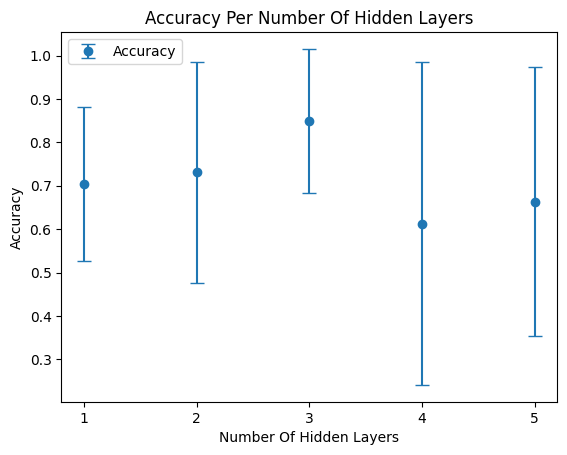

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

mean_acc = [acc1.mean(), acc2.mean(), acc3.mean(), acc4.mean(), acc5.mean()]
var_acc = [acc1.var(), acc2.var(), acc3.var(), acc4.var(), acc5.var()]

x_labels = ['1', '2', '3', '4', '5']

plt.errorbar(x_labels, mean_acc, yerr=np.sqrt(var_acc), fmt='o', label='Accuracy', capsize=5)

plt.xlabel('Number Of Hidden Layers')
plt.ylabel('Accuracy')
plt.title('Accuracy Per Number Of Hidden Layers')

plt.legend()

plt.show()

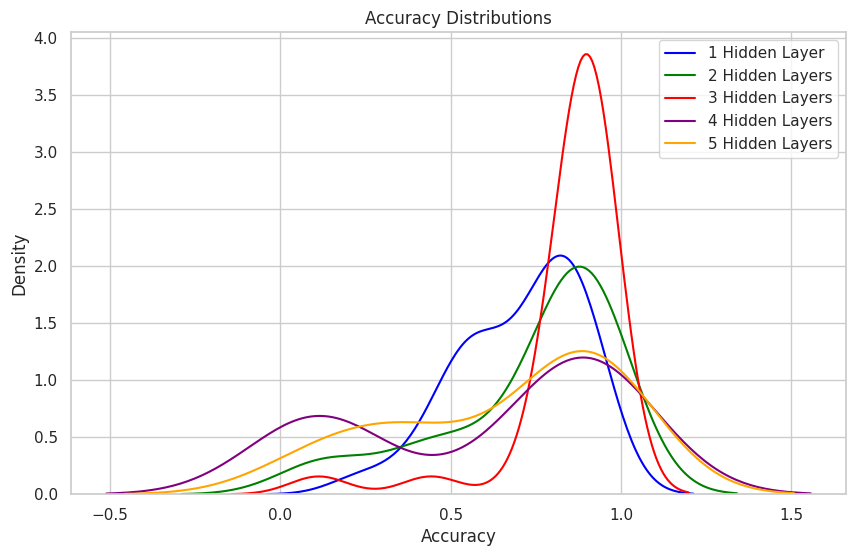

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))

sns.kdeplot(acc1, label='1 Hidden Layer', color='blue')
sns.kdeplot(acc2, label='2 Hidden Layers', color='green')
sns.kdeplot(acc3, label='3 Hidden Layers', color='red')
sns.kdeplot(acc4, label='4 Hidden Layers', color='purple')
sns.kdeplot(acc5, label='5 Hidden Layers', color='orange')

plt.xlabel('Accuracy')
plt.ylabel('Density')
plt.title('Accuracy Distributions')

plt.legend()

plt.show()


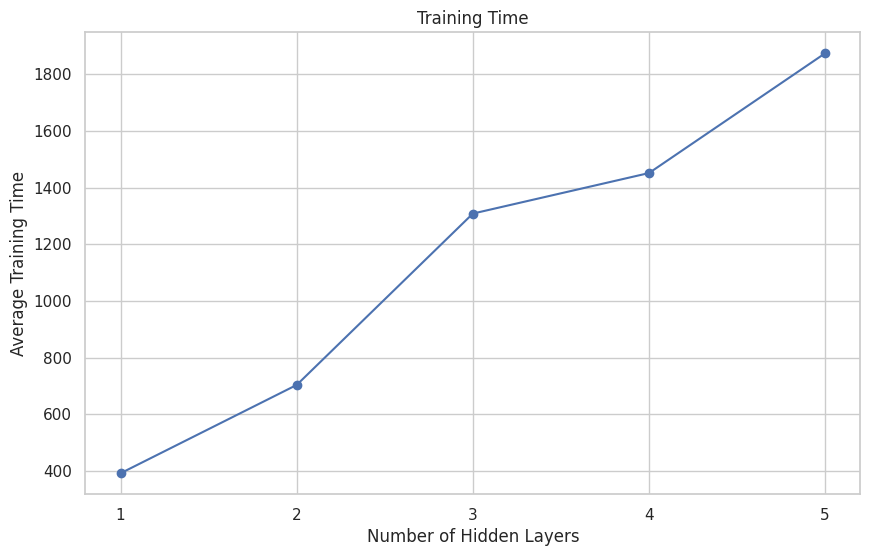

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

train_times = [train_time1, train_time2, train_time3, train_time4, train_time5]

groups = ['1', '2', '3', '4', '5']

plt.figure(figsize=(10, 6))

plt.errorbar(groups, [np.mean(t) for t in train_times], marker='o', linestyle='-', color='b')

plt.xlabel('Number of Hidden Layers')
plt.ylabel('Average Training Time')
plt.title('Training Time')

plt.show()


#Chosing hyperparamaters with genetic algorithm. Highest validation accuracy would be the chosen one

##3 hidden layers network with dropout and l2 regularization

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

def create_model(neurons, dropout_rate, weight_decay, learning_rate):
    model = Sequential()
    model.add(Dense(neurons[0], activation='relu', kernel_regularizer=l2(weight_decay[0])))
    model.add(Dropout(dropout_rate[0]))
    model.add(Dense(neurons[1], activation='relu', kernel_regularizer=l2(weight_decay[1])))
    model.add(Dropout(dropout_rate[1]))
    model.add(Dense(neurons[2], activation='relu', kernel_regularizer=l2(weight_decay[2])))
    model.add(Dropout(dropout_rate[2]))
    model.add(Dense(10, activation='softmax'))

    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])
    return model


##Genetic Algorithm

In [ ]:
import random as rd

#The configurations possible for each individual
params_grid = {
  'neurons': [16, 32, 64, 128, 256, 512],
  'learning_rate' : [1e-2, 1e-3, 1e-4, 1e-5],
  'batch_size' : [32, 64, 128, 256],
  'epochs' : [10, 50, 100, 150, 200, 250],
  'weight_decay': [0, 1e-2, 1e-3, 1e-4, 1e-5],
  'drop_rate': [0, 0.1, 0.2, 0.3, 0.4, 0.5]
}

#Store models accuracy and configurations
memory = {}

#Population inititalizer for genetic algorithm
def gen_population(size=20):
  population = []
  for i in range(size):
    individual = {
      'neurons': sorted([rd.choice(params_grid['neurons']) for ii in range(3)], reverse=True),
      'learning_rate': rd.choice(params_grid['learning_rate']),
      'batch_size': rd.choice(params_grid['batch_size']),
      'epochs': rd.choice(params_grid['epochs']),
      'weight_decay': [rd.choice(params_grid['weight_decay']) for ii in range(3)],
      'drop_rate': [rd.choice(params_grid['drop_rate']) for ii in range(3)]
    }
    population.append(individual)
  return population

#Train and get Validation accuracy from selected individual
def evaluate_invidual(individual):
  print(individual)
  if str(individual) not in memory:
    model = create_model(individual['neurons'],individual['drop_rate'],individual['weight_decay'],individual['learning_rate'])
    result = model.fit(x_train, y_train, epochs=individual['epochs'], batch_size=individual['batch_size'], validation_data=(x_valid, y_valid), verbose=0)
    accuracy = result.history['val_accuracy'][-1]
    memory[str(individual)] = accuracy
    print(f"Validation accuracy: {accuracy}")
  return memory[str(individual)]

#Mutation simulator, change the configuration of the individual randomly
def mutate(individual, mutation_rate=0.1):
  for prop in individual:
    if rd.random() < mutation_rate:
      if prop == 'neurons':
        individual[prop] = sorted([rd.choice(params_grid['neurons']) for ii in range(3)], reverse=True)
      elif prop == 'learning_rate' or prop == 'batch_size' or prop == 'epochs':
        individual[prop] = rd.choice(params_grid[prop])
      else:
        individual[prop] = [rd.choice(params_grid[prop]) for ii in range(3)]
  return individual

#Mating simulator, create a new individual with selected parents
def crossover(p1, p2):
  child = {}
  for prop in p1:
    if rd.random() < 0.5:
      child[prop] = p1[prop]
    else:
      child[prop] = p2[prop]
  return child

#Natural selection simulator, select best individuals(survivals) by their validation accuracy
def selection(population, survivals):
  eval_population = [(evaluate_invidual(individual), individual) for individual in population]
  eval_population.sort(key=lambda x: x[0], reverse=True)
  print(f"Recent record: {eval_population[0][1]}")
  return [ind[1] for ind in eval_population[:survivals]]

def gen_alg(size=20, generations=15, survivals=10):
  population = gen_population(size)
  for generation in range(generations):
    print(f"Generation {generation+1}/{generations}")
    print("Population: ")
    for individual in population:
      print(individual)
    print("--------------------------------------------------------------------------------")
    new_population = selection(population, survivals)
    while len(new_population) < size:
      parent1 = rd.choice(new_population)
      parent2 = rd.choice(new_population)
      child = crossover(parent1, parent2)
      child = mutate(child)
      new_population.append(child)
    population = new_population
  return selection(population, 1)[1]


##This donut takes decades, so just take the result behind and skip this shell

In [ ]:
best_combo = gen_alg()
print(f"Best combination {best_combo}")

Generation 1/15
Population: 
{'neurons': [64, 16, 16], 'learning_rate': 1e-05, 'batch_size': 64, 'epochs': 100, 'weight_decay': [1e-05, 0.0001, 0.0001], 'drop_rate': [0.2, 0.5, 0]}
{'neurons': [256, 128, 32], 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 250, 'weight_decay': [1e-05, 0.01, 1e-05], 'drop_rate': [0.5, 0.4, 0.2]}
{'neurons': [512, 64, 32], 'learning_rate': 0.0001, 'batch_size': 128, 'epochs': 250, 'weight_decay': [0, 0.01, 1e-05], 'drop_rate': [0.2, 0, 0.1]}
{'neurons': [256, 256, 16], 'learning_rate': 0.0001, 'batch_size': 128, 'epochs': 100, 'weight_decay': [0.001, 0.0001, 1e-05], 'drop_rate': [0.1, 0.4, 0.2]}
{'neurons': [512, 256, 32], 'learning_rate': 0.001, 'batch_size': 256, 'epochs': 50, 'weight_decay': [1e-05, 0, 1e-05], 'drop_rate': [0.1, 0.1, 0.1]}
{'neurons': [128, 64, 32], 'learning_rate': 0.001, 'batch_size': 64, 'epochs': 100, 'weight_decay': [1e-05, 0.01, 1e-05], 'drop_rate': [0.3, 0.1, 0.2]}
{'neurons': [64, 32, 16], 'learning_rate': 1e-05, 'batch_siz

KeyboardInterrupt: 

In [ ]:
for record in memory:
  print(f"{record} - Accuracy for validation set: {memory[record]}")

NameError: name 'memory' is not defined

#GPU runtime died, continue with 5th generation

In [ ]:
memory = {}
generation = 5
current_population = [
{'neurons': [512, 256, 16], 'learning_rate': 0.0001, 'batch_size': 32, 'epochs': 250, 'weight_decay': [1e-05, 0, 1e-05], 'drop_rate': [0.3, 0.3, 0.2]},
{'neurons': [512, 256, 16], 'learning_rate': 0.0001, 'batch_size': 32, 'epochs': 250, 'weight_decay': [0.001, 0, 0.0001], 'drop_rate': [0.3, 0.3, 0.2]},
{'neurons': [512, 512, 256], 'learning_rate': 0.0001, 'batch_size': 64, 'epochs': 150, 'weight_decay': [0.001, 0.0001, 1e-05], 'drop_rate': [0.1, 0.5, 0.4]},
{'neurons': [256, 256, 16], 'learning_rate': 0.0001, 'batch_size': 64, 'epochs': 250, 'weight_decay': [0.001, 0.0001, 1e-05], 'drop_rate': [0.2, 0, 0.1]},
{'neurons': [512, 256, 32], 'learning_rate': 0.0001, 'batch_size': 128, 'epochs': 250, 'weight_decay': [0.001, 0, 0.0001], 'drop_rate': [0.1, 0.4, 0.2]},
{'neurons': [512, 256, 16], 'learning_rate': 0.0001, 'batch_size': 32, 'epochs': 50, 'weight_decay': [1e-05, 0, 1e-05], 'drop_rate': [0.3, 0.3, 0.2]},
{'neurons': [512, 256, 32], 'learning_rate': 0.001, 'batch_size': 256, 'epochs': 50, 'weight_decay': [1e-05, 0, 1e-05], 'drop_rate': [0.1, 0.1, 0.1]},
{'neurons': [512, 128, 64], 'learning_rate': 0.0001, 'batch_size': 128, 'epochs': 250, 'weight_decay': [0, 0.01, 1e-05], 'drop_rate': [0.4, 0.5, 0.5]},
{'neurons': [512, 256, 32], 'learning_rate': 0.0001, 'batch_size': 32, 'epochs': 50, 'weight_decay': [1e-05, 0, 1e-05], 'drop_rate': [0.4, 0.3, 0.3]},
{'neurons': [256, 256, 16], 'learning_rate': 0.0001, 'batch_size': 32, 'epochs': 100, 'weight_decay': [0.001, 0.0001, 1e-05], 'drop_rate': [0.1, 0.4, 0.2]},
{'neurons': [512, 256, 16], 'learning_rate': 0.0001, 'batch_size': 64, 'epochs': 250, 'weight_decay': [1e-05, 0, 1e-05], 'drop_rate': [0.5, 0, 0.1]},
{'neurons': [512, 256, 16], 'learning_rate': 0.0001, 'batch_size': 64, 'epochs': 250, 'weight_decay': [0.001, 0, 0.0001], 'drop_rate': [0.3, 0.3, 0.2]},
{'neurons': [512, 512, 256], 'learning_rate': 0.0001, 'batch_size': 64, 'epochs': 150, 'weight_decay': [1e-05, 0, 1e-05], 'drop_rate': [0.5, 0, 0.3]},
{'neurons': [512, 256, 16], 'learning_rate': 0.0001, 'batch_size': 32, 'epochs': 50, 'weight_decay': [0.001, 0, 0.0001], 'drop_rate': [0.3, 0.3, 0.2]},
{'neurons': [512, 256, 16], 'learning_rate': 0.001, 'batch_size': 64, 'epochs': 250, 'weight_decay': [1e-05, 0, 1e-05], 'drop_rate': [0.5, 0, 0.1]},
{'neurons': [512, 256, 16], 'learning_rate': 0.0001, 'batch_size': 32, 'epochs': 250, 'weight_decay': [0, 0.01, 0.0001], 'drop_rate': [0, 0, 0.3]},
{'neurons': [512, 256, 16], 'learning_rate': 0.0001, 'batch_size': 32, 'epochs': 50, 'weight_decay': [1e-05, 0, 1e-05], 'drop_rate': [0.3, 0.5, 0.3]},
{'neurons': [512, 256, 16], 'learning_rate': 0.001, 'batch_size': 64, 'epochs': 50, 'weight_decay': [1e-05, 0, 1e-05], 'drop_rate': [0.5, 0, 0.1]},
{'neurons': [512, 256, 16], 'learning_rate': 0.0001, 'batch_size': 64, 'epochs': 50, 'weight_decay': [1e-05, 0, 1e-05], 'drop_rate': [0.5, 0, 0.1]},
{'neurons': [512, 256, 32], 'learning_rate': 0.0001, 'batch_size': 32, 'epochs': 150, 'weight_decay': [0.001, 0.0001, 1e-05], 'drop_rate': [0.5, 0.2, 0.1]}
]

def gen_alg_cont(input_pop, size=20, generations=15, survivals=10):
  population = input_pop
  for generation in range(4,generations):
    print(f"Generation {generation+1}/{generations}")
    print("Population: ")
    for individual in population:
      print(individual)
    print("--------------------------------------------------------------------------------")
    new_population = selection(population, survivals)
    while len(new_population) < size:
      parent1 = rd.choice(new_population)
      parent2 = rd.choice(new_population)
      child = crossover(parent1, parent2)
      child = mutate(child)
      new_population.append(child)
    population = new_population
  return selection(population, 1)[1]

best_combo = gen_alg_cont(current_population)
print(f"Best combination {best_combo}")


Generation 5/15
Population: 
{'neurons': [512, 256, 16], 'learning_rate': 0.0001, 'batch_size': 32, 'epochs': 250, 'weight_decay': [1e-05, 0, 1e-05], 'drop_rate': [0.3, 0.3, 0.2]}
{'neurons': [512, 256, 16], 'learning_rate': 0.0001, 'batch_size': 32, 'epochs': 250, 'weight_decay': [0.001, 0, 0.0001], 'drop_rate': [0.3, 0.3, 0.2]}
{'neurons': [512, 512, 256], 'learning_rate': 0.0001, 'batch_size': 64, 'epochs': 150, 'weight_decay': [0.001, 0.0001, 1e-05], 'drop_rate': [0.1, 0.5, 0.4]}
{'neurons': [256, 256, 16], 'learning_rate': 0.0001, 'batch_size': 64, 'epochs': 250, 'weight_decay': [0.001, 0.0001, 1e-05], 'drop_rate': [0.2, 0, 0.1]}
{'neurons': [512, 256, 32], 'learning_rate': 0.0001, 'batch_size': 128, 'epochs': 250, 'weight_decay': [0.001, 0, 0.0001], 'drop_rate': [0.1, 0.4, 0.2]}
{'neurons': [512, 256, 16], 'learning_rate': 0.0001, 'batch_size': 32, 'epochs': 50, 'weight_decay': [1e-05, 0, 1e-05], 'drop_rate': [0.3, 0.3, 0.2]}
{'neurons': [512, 256, 32], 'learning_rate': 0.001, 'b

KeyboardInterrupt: 

##Runtime Died, so i'll take the record of the 6th generation

#Train and test with the chosen one

Epoch 1/250
1500/1500 - 7s - 5ms/step - accuracy: 0.5004 - loss: 1.4763 - val_accuracy: 0.7642 - val_loss: 0.7742
Epoch 2/250
1500/1500 - 3s - 2ms/step - accuracy: 0.7484 - loss: 0.8029 - val_accuracy: 0.8526 - val_loss: 0.5025
Epoch 3/250
1500/1500 - 3s - 2ms/step - accuracy: 0.8116 - loss: 0.6134 - val_accuracy: 0.8823 - val_loss: 0.4043
Epoch 4/250
1500/1500 - 3s - 2ms/step - accuracy: 0.8393 - loss: 0.5145 - val_accuracy: 0.8972 - val_loss: 0.3462
Epoch 5/250
1500/1500 - 3s - 2ms/step - accuracy: 0.8613 - loss: 0.4537 - val_accuracy: 0.9075 - val_loss: 0.3106
Epoch 6/250
1500/1500 - 3s - 2ms/step - accuracy: 0.8734 - loss: 0.4073 - val_accuracy: 0.9132 - val_loss: 0.2900
Epoch 7/250
1500/1500 - 3s - 2ms/step - accuracy: 0.8843 - loss: 0.3733 - val_accuracy: 0.9183 - val_loss: 0.2707
Epoch 8/250
1500/1500 - 3s - 2ms/step - accuracy: 0.8950 - loss: 0.3450 - val_accuracy: 0.9233 - val_loss: 0.2593
Epoch 9/250
1500/1500 - 3s - 2ms/step - accuracy: 0.9030 - loss: 0.3185 - val_accuracy: 

Model: "sequential_28"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_112 (Dense)                    │ (32, 512)                   │         401,920 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_84 (Dropout)                 │ (32, 512)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_113 (Dense)                    │ (32, 512)                   │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_85 (Dropout)                 │ (32, 512)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_114 (Dense)                    │ (32, 256)                   │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_86 (Dropout)                 │ (32, 256)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_115 (Dense)                    │ (32, 10)                    │           2,570 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,395,424 (9.14 MB)

 Trainable params: 798,474 (3.05 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,596,950 (6.09 MB)

313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step
F1 Score: 0.9705428597152566
Recall Score: 0.9702106896514453
[[ 965    2    3    0    0    2    3    4    1    0]
 [   0 1130    2    1    0    0    1    1    0    0]
 [   0    7 1003    5    1    0    0   15    1    0]
 [   0    0    2  992    0    3    0   11    1    1]
 [   0    2    4    0  963    0    0    5    0    8]
 [   0    2    0   19    1  864    1    2    0    3]
 [   4    4    1    1    2   10  934    0    2    0]
 [   0    1   17    0    1    0    0 1009    0    0]
 [   2   10    4   14    7    8    2    8  912    7]
 [   0    7    0    6   37    0    0   24    1  934]]


<Figure size 640x480 with 0 Axes>

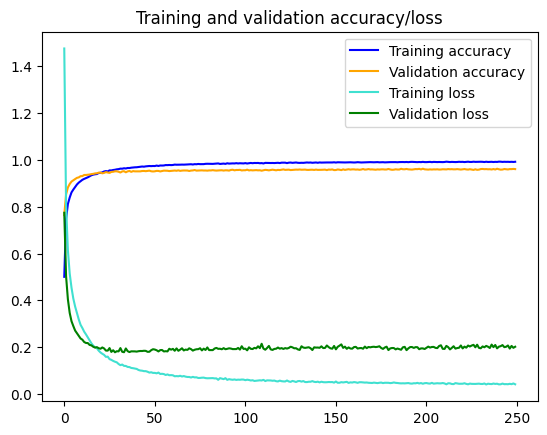

<Figure size 640x480 with 0 Axes>

In [ ]:
from sklearn.metrics import f1_score, recall_score, confusion_matrix

chosen_one = {'neurons': [512, 512, 256], 'learning_rate': 0.0001, 'batch_size': 32, 'epochs': 250, 'weight_decay': [1e-05, 0, 1e-05], 'drop_rate': [0.5, 0, 0.3]}
model = create_model(chosen_one['neurons'],chosen_one['drop_rate'],chosen_one['weight_decay'],chosen_one['learning_rate'])

history = model.fit(x_train, y_train, epochs=chosen_one['epochs'], batch_size=chosen_one['batch_size'], validation_data=(x_valid,y_valid), verbose=2)
model.summary()
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

f1 = f1_score(y_test_classes, y_pred_classes, average='macro')
recall = recall_score(y_test_classes, y_pred_classes, average='macro')
print(f"F1 Score: {f1}")
print(f"Recall Score: {recall}")
print(confusion_matrix(y_test_classes, y_pred_classes))

train_acc = history.history['accuracy']
validate_acc = history.history['val_accuracy']
train_loss = history.history['loss']
validate_loss = history.history['val_loss']

plt.title("Result")
plt.plot(train_acc, color = 'blue', label='Training accuracy')
plt.plot(validate_acc, color = 'orange', label='Validation accuracy')
plt.plot(train_loss, color = 'turquoise', label='Training loss')
plt.plot(validate_loss, color = 'green', label='Validation loss')
plt.title('Training and validation accuracy/loss')
plt.legend()
plt.figure()

In [ ]:
model.evaluate(x_test,y_test, batch_size=chosen_one['batch_size'], verbose=2)

313/313 - 3s - 9ms/step - accuracy: 0.9706 - loss: 0.1720


[0.17204894125461578, 0.9706000089645386]

In [ ]:
model.save('model.h5')

In [ ]:
test_model = keras.models.load_model('model.h5')

###confusion matrix of the selected model with augmentation

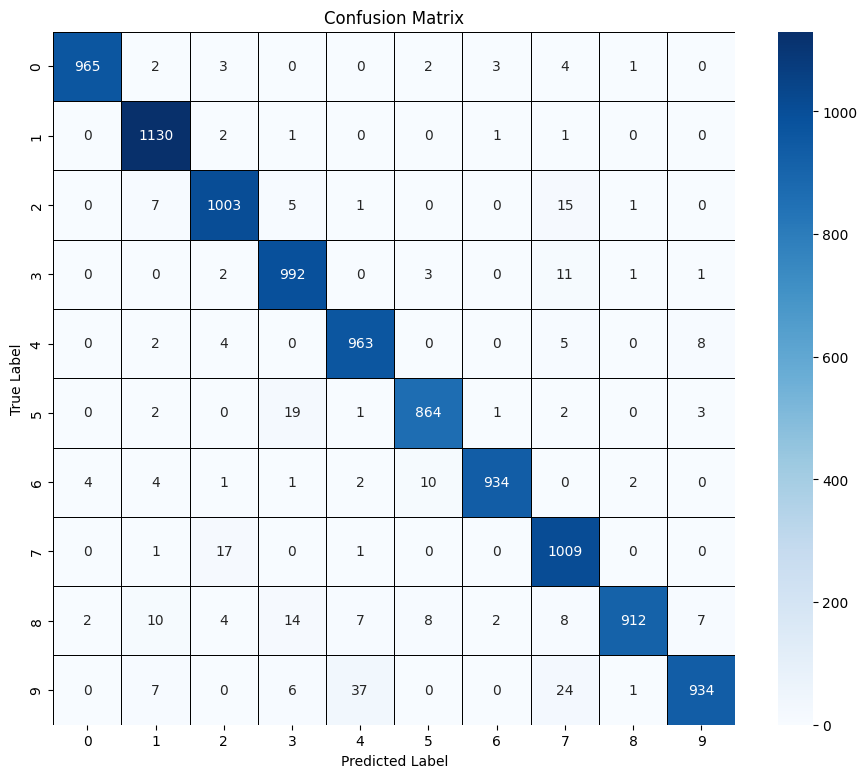

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

confusion_matrix = np.array([
    [965, 2, 3, 0, 0, 2, 3, 4, 1, 0],
    [0, 1130, 2, 1, 0, 0, 1, 1, 0, 0],
    [0, 7, 1003, 5, 1, 0, 0, 15, 1, 0],
    [0, 0, 2, 992, 0, 3, 0, 11, 1, 1],
    [0, 2, 4, 0, 963, 0, 0, 5, 0, 8],
    [0, 2, 0, 19, 1, 864, 1, 2, 0, 3],
    [4, 4, 1, 1, 2, 10, 934, 0, 2, 0],
    [0, 1, 17, 0, 1, 0, 0, 1009, 0, 0],
    [2, 10, 4, 14, 7, 8, 2, 8, 912, 7],
    [0, 7, 0, 6, 37, 0, 0, 24, 1, 934]
])

plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=range(10), yticklabels=range(10), linewidth=0.5, linecolor='black' ,)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


#Without Augmentation

In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import l2

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.reshape(-1, 28 * 28) / 255.0
x_test = x_test.reshape(-1, 28 * 28) / 255.0

y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

model = Sequential([
    Dense(512, activation='relu', kernel_regularizer=l2(1e-5)),
    Dropout(0.5),
    Dense(512, activation='relu', kernel_regularizer=l2(0)),
    Dropout(0),
    Dense(256, activation='relu', kernel_regularizer=l2(1e-5)),
    Dropout(0.3),
    Dense(10, activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(x_train, y_train, epochs=250, batch_size=32, verbose=2)
model.evaluate(x_test, y_test, verbose=2)

Epoch 1/250


KeyboardInterrupt: 

In [ ]:
model.save('model_wo_aug.h5')

#So augmentation is no need for the mnist dataset

#Checkpoint for numpy model

#Imitate a model using numpy
##First try

##Import libraries

In [ ]:
import tensorflow as tf
import tensorflow.keras.datasets.mnist as mnist
import numpy as np
from sklearn.metrics import recall_score, f1_score as f1
import matplotlib.pyplot as plt
import pickle

###Config GPU runtime

In [ ]:
physical_devices = tf.config.list_physical_devices(device_type='GPU')
if(len(physical_devices)!=0):
  tf.config.experimental.set_memory_growth(physical_devices[0],True)
print(physical_devices)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


###Helper funtions: relu,softmax, crossentropy and their derivirites

In [ ]:
x = np.array([-1,-1,1,1,1,2,3,4])

def relu(x):
  return np.maximum(0, x)

print(relu(x))

def d_relu(x):
  return np.where(x>0,1,0)

print(d_relu(x))

def softmax(x):
    exps = np.exp(x - np.max(x, axis=1, keepdims=True))
    return exps / np.sum(exps, axis=1, keepdims=True)

x=[[1,1,1],[1,1,1]]

print(softmax(x))

def crossentropy(y_pred, y_true):
    epsilon = 1e-15
    y_pred_clipped = np.clip(y_pred, epsilon, 1 - epsilon)
    return -np.sum(y_true * np.log(y_pred_clipped), axis=1) #Ensure the logarit is in range (0,1)

def d_crossentropy(y_pred, y_true):
    return y_pred - y_true

[0 0 1 1 1 2 3 4]
[0 0 1 1 1 1 1 1]
[[0.33333333 0.33333333 0.33333333]
 [0.33333333 0.33333333 0.33333333]]


In [ ]:
class Layer:
    def __init__(self, input_size, output_size, weight_decay, learning_rate=0.001, b1=0.9, b2=0.999, e=1e-8):
      #Weight and bias matricies
        self.w = np.random.randn(input_size, output_size)
        self.b = np.random.randn(1, output_size)
      #L2 regulation params
        self.weight_decay = weight_decay
      #Adam params
        self.learning_rate = learning_rate
        self.b1 = b1
        self.b2 = b2
        self.e = e
        self.m_w, self.v_w = np.zeros_like(self.w), np.zeros_like(self.w)
        self.m_b, self.v_b = np.zeros_like(self.b), np.zeros_like(self.b)
        self.t = 0

    def forward(self, inputs):
        self.inputs = inputs
        self.output = np.dot(inputs, self.w) + self.b
        return self.output

    def back_prop(self, dval):
        self.dw = np.dot(self.inputs.T, dval) + self.weight_decay * self.w
        self.db = np.sum(dval, axis=0, keepdims=True)
        self.t += 1
        self.m_w = self.b1 * self.m_w + (1 - self.b1) * self.dw
        self.v_w = self.b2 * self.v_w + (1 - self.b2) * (self.dw ** 2)
        m_w_hat = self.m_w / (1 - self.b1 ** self.t)
        v_w_hat = self.v_w / (1 - self.b2 ** self.t)
        self.w -= self.learning_rate * m_w_hat / (np.sqrt(v_w_hat) + self.e)
        self.m_b = self.b1 * self.m_b + (1 - self.b1) * self.db
        self.v_b = self.b2 * self.v_b + (1 - self.b2) * (self.db ** 2)
        m_b_hat = self.m_b / (1 - self.b1 ** self.t)
        v_b_hat = self.v_b / (1 - self.b2 ** self.t)
        self.b -= self.learning_rate * m_b_hat / (np.sqrt(v_b_hat) + self.e)
        self.dinputs = np.dot(dval, self.w.T)

class Dropout:
    def __init__(self, drop_rate):
        self.drop_rate = drop_rate

    def forward(self, inputs):
        self.mask = np.random.rand(*inputs.shape) > self.drop_rate
        self.output = inputs * self.mask / (1 - self.drop_rate) #Scale up the matrix so that the sum remains intact
        return self.output

    def back_prop(self, dval):
        self.dinputs = dval * self.mask / (1 - self.drop_rate)

#Feed Forward neural network
class FFN:
    def __init__(self, neurons, drop_rate, weight_decay, learning_rate):
        self.layers = [
            Layer(784, neurons[0], weight_decay[0], learning_rate),
            Dropout(drop_rate[0]),
            Layer(neurons[0], neurons[1], weight_decay[1], learning_rate),
            Dropout(drop_rate[1]),
            Layer(neurons[1], neurons[2], weight_decay[2], learning_rate),
            Dropout(drop_rate[2]),
            Layer(neurons[2], 10, 0, learning_rate)
        ]

    def forward(self, x):
        for layer in self.layers:
            if isinstance(layer, Layer):
              if layer != self.layers[-1]:
                x = relu(layer.forward(x))
              else:
                x = softmax(layer.forward(x))
            else:
                x = layer.forward(x)
        return x

    def back_prop(self, dval, y_true):
        for layer in reversed(self.layers):
            if isinstance(layer, Layer):
                layer.back_prop(dval)
                dval = d_relu(layer.inputs) * layer.dinputs
            elif isinstance(layer, Dropout):
                layer.back_prop(dval)
                dval = layer.dinputs

    def train(self, x, y, epochs, batch_size):
        history = {'loss': [], 'accuracy': [], 'recall': [], 'f1_score': []}

        for epoch in range(epochs):
            epoch_loss, correct_predictions = 0, 0
            all_preds, all_labels = [], []

            for i in range(0, x.shape[0], batch_size):
                x_batch = x[i:i + batch_size]
                y_batch = y[i:i + batch_size]

                predictions = self.forward(x_batch)
                loss = np.mean(crossentropy(predictions, y_batch))
                epoch_loss += loss

                y_pred = np.argmax(predictions, axis=1)
                y_true = np.argmax(y_batch, axis=1)
                all_preds.extend(y_pred)
                all_labels.extend(y_true)

                correct_predictions += np.sum(y_pred == y_true)

                dval = predictions - y_batch
                self.back_prop(dval, y_batch)

            accuracy = correct_predictions / x.shape[0]
            recall = recall_score(all_labels, all_preds, average='macro')
            f1_sc = f1(all_labels, all_preds, average='macro')
            history['loss'].append(epoch_loss / (x.shape[0] / batch_size))
            history['accuracy'].append(accuracy)
            history['recall'].append(recall)
            history['f1_score'].append(f1_sc)

            print(f'Epoch {epoch + 1}/{epochs}, Loss: {history["loss"][-1]:.4f}, '
                  f'Accuracy: {accuracy:.4f}, Recall: {recall:.4f}, F1 Score: {f1_sc:.4f}')

        return history

    def test(self, x_test, y_test):
        predictions = self.forward(x_test)
        test_loss = np.mean(crossentropy(predictions, y_test))

        y_pred = np.argmax(predictions, axis=1)
        y_true = np.argmax(y_test, axis=1)
        accuracy = np.mean(y_pred == y_true)
        recall = recall_score(y_true, y_pred, average='macro')
        f1_sc = f1(y_true, y_pred, average='macro')

        print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {accuracy:.4f}, '
              f'Test Recall: {recall:.4f}, Test F1 Score: {f1_sc:.4f}')

        return test_loss, accuracy, recall, f1_sc

    def save(self, filename):
        with open(filename, 'wb') as f:
            model_data = {'layers': [(layer.w, layer.b) for layer in self.layers if isinstance(layer, Layer)]}
            pickle.dump(model_data, f)

    def load(self, filename):
        with open(filename, 'rb') as f:
            model_data = pickle.load(f)
            layer_params = model_data['layers']
            for i, (w, b) in enumerate(layer_params):
                self.layers[i * 2].w = w #Skip the dropout layers
                self.layers[i * 2].b = b


In [ ]:
best_ind = {'neurons': [512, 256, 16], 'learning_rate': 0.0001, 'batch_size': 32, 'epochs': 250, 'weight_decay': [1e-05, 0, 1e-05], 'drop_rate': [0.3, 0.3, 0.2]} #From the genetic algorithm above


In [ ]:
model = FFN(best_ind['neurons'], best_ind['drop_rate'], best_ind['weight_decay'], best_ind['learning_rate'])
history = model.train(x_train, y_train, epochs=best_ind['epochs'], batch_size=best_ind['batch_size'])
test_loss, accuracy, recall, f1 = model.test(x_test, y_test)
plt.plot(history['loss'], label='Loss')
plt.plot(history['accuracy'], label='Accuracy')
plt.plot(history['recall'], label='Recall')
plt.plot(history['f1_score'], label='F1 Score')
plt.xlabel('Epoch')
plt.ylabel('Metrics')
plt.legend()
plt.show()

ValueError: operands could not be broadcast together with shapes (32,10,10) (32,10) 

##Fail due to weight initialization is random, the accuracy remains 10%

#With He initializer

In [ ]:
import tensorflow as tf
import tensorflow.keras.datasets.mnist as mnist
import numpy as np
from sklearn.metrics import recall_score, f1_score as f1
import matplotlib.pyplot as plt
import pickle
from tensorflow.keras.utils import to_categorical

In [ ]:
physical_devices = tf.config.list_physical_devices(device_type='GPU')
if(len(physical_devices)!=0):
  tf.config.experimental.set_memory_growth(physical_devices[0],True)
print(physical_devices)

[]


In [ ]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
x_train = x_train.reshape(-1, 28 * 28)
x_test = x_test.reshape(-1, 28 * 28)
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

x_valid = x_train[-10000:]
x_train = x_train[:-10000]
y_valid = y_train[-10000:]
y_train = y_train[:-10000]

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
def relu(x):
    return np.maximum(0, x)

def d_relu(x):
    return np.where(x > 0, 1, 0)

def softmax(x):
    exps = np.exp(x - np.max(x, axis=1, keepdims=True))
    return exps / np.sum(exps, axis=1, keepdims=True)

def crossentropy(y_pred, y_true):
    epsilon = 1e-15
    y_pred_clipped = np.clip(y_pred, epsilon, 1 - epsilon)
    return -np.sum(y_true * np.log(y_pred_clipped), axis=1)

In [ ]:
class Layer:
    def __init__(self, input_size, output_size, weight_decay, learning_rate=0.001, b1=0.9, b2=0.999, e=1e-8):
        self.w = np.random.randn(input_size, output_size) * np.sqrt(2 / input_size)  # He init
        self.b = np.zeros((1, output_size))
        self.weight_decay = weight_decay
        self.learning_rate = learning_rate
        self.b1 = b1
        self.b2 = b2
        self.e = e
        self.m_w, self.v_w = np.zeros_like(self.w), np.zeros_like(self.w)
        self.m_b, self.v_b = np.zeros_like(self.b), np.zeros_like(self.b)
        self.t = 0

    def forward(self, inputs):
        self.inputs = inputs
        self.output = np.dot(inputs, self.w) + self.b
        return self.output

    def back_prop(self, dval):
        self.dw = np.dot(self.inputs.T, dval) + self.weight_decay * self.w
        self.db = np.sum(dval, axis=0, keepdims=True)
        self.t += 1
        self.m_w = self.b1 * self.m_w + (1 - self.b1) * self.dw
        self.v_w = self.b2 * self.v_w + (1 - self.b2) * (self.dw ** 2)
        m_w_hat = self.m_w / (1 - self.b1 ** self.t)
        v_w_hat = self.v_w / (1 - self.b2 ** self.t)
        self.w -= self.learning_rate * m_w_hat / (np.sqrt(v_w_hat) + self.e)
        self.m_b = self.b1 * self.m_b + (1 - self.b1) * self.db
        self.v_b = self.b2 * self.v_b + (1 - self.b2) * (self.db ** 2)
        m_b_hat = self.m_b / (1 - self.b1 ** self.t)
        v_b_hat = self.v_b / (1 - self.b2 ** self.t)
        self.b -= self.learning_rate * m_b_hat / (np.sqrt(v_b_hat) + self.e)
        self.dinputs = np.dot(dval, self.w.T)

In [ ]:
class Dropout:
    def __init__(self, drop_rate):
        self.drop_rate = drop_rate

    def forward(self, inputs, training=True):
        if training:
            self.mask = np.random.rand(*inputs.shape) > self.drop_rate
            self.output = inputs * self.mask / (1 - self.drop_rate)
        else:
            self.output = inputs
        return self.output

    def back_prop(self, dval):
        self.dinputs = dval * self.mask / (1 - self.drop_rate)

In [ ]:
class FFN:
    def __init__(self, neurons, drop_rate, weight_decay, learning_rate):
        self.layers = [
            Layer(784, neurons[0], weight_decay[0], learning_rate),
            Dropout(drop_rate[0]),
            Layer(neurons[0], neurons[1], weight_decay[1], learning_rate),
            Dropout(drop_rate[1]),
            Layer(neurons[1], neurons[2], weight_decay[2], learning_rate),
            Dropout(drop_rate[2]),
            Layer(neurons[2], 10, 0, learning_rate)
        ]

    def forward(self, x, training=True):
        for layer in self.layers:
            if isinstance(layer, Layer):
                if layer != self.layers[-1]:
                    x = relu(layer.forward(x))
                else:
                    x = softmax(layer.forward(x))
            else:
                x = layer.forward(x, training)
        return x

    def back_prop(self, dval):
        for layer in reversed(self.layers):
            if isinstance(layer, Layer):
                layer.back_prop(dval)
                dval = d_relu(layer.inputs) * layer.dinputs
            elif isinstance(layer, Dropout):
                layer.back_prop(dval)
                dval = layer.dinputs

    def test(self, x_test, y_test):
        predictions = self.forward(x_test, training=False)
        loss = np.mean(crossentropy(predictions, y_test))

        y_pred = np.argmax(predictions, axis=1)
        y_true = np.argmax(y_test, axis=1)
        accuracy = np.mean(y_pred == y_true)
        recall = recall_score(y_true, y_pred, average='macro')
        f1_sc = f1(y_true, y_pred, average='macro')

        print(f'Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}, '
              f'Test Recall: {recall:.4f}, Test F1 Score: {f1_sc:.4f}')

        return loss, accuracy, recall, f1_sc

    def validate(self, x_valid, y_valid):
        predictions = self.forward(x_valid, training=False)
        loss = np.mean(crossentropy(predictions, y_valid))

        y_pred = np.argmax(predictions, axis=1)
        y_true = np.argmax(y_valid, axis=1)
        accuracy = np.mean(y_pred == y_true)
        recall = recall_score(y_true, y_pred, average='macro')
        f1_sc = f1(y_true, y_pred, average='macro')

        return loss, accuracy, recall, f1_sc

    def train(self, x, y, epochs, batch_size):
        history = {'loss': [], 'accuracy': [], 'recall': [], 'f1_score': [], 'val_loss': [], 'val_accuracy': [], 'val_recall': [], 'val_f1_score': []}

        for epoch in range(epochs):
            epoch_loss, correct_predictions = 0, 0
            all_preds, all_labels = [], []

            for i in range(0, x.shape[0], batch_size):
                x_batch = x[i:i + batch_size]
                y_batch = y[i:i + batch_size]

                predictions = self.forward(x_batch, training=True)
                loss = np.mean(crossentropy(predictions, y_batch))
                epoch_loss += loss

                y_pred = np.argmax(predictions, axis=1)
                y_true = np.argmax(y_batch, axis=1)
                all_preds.extend(y_pred)
                all_labels.extend(y_true)

                correct_predictions += np.sum(y_pred == y_true)

                dval = predictions - y_batch
                self.back_prop(dval)

            accuracy = correct_predictions / x.shape[0]
            recall = recall_score(all_labels, all_preds, average='macro')
            f1_sc = f1(all_labels, all_preds, average='macro')
            history['loss'].append(epoch_loss / (x.shape[0] / batch_size))
            history['accuracy'].append(accuracy)
            history['recall'].append(recall)
            history['f1_score'].append(f1_sc)

            print(f'Epoch {epoch + 1}/{epochs}, Loss: {history["loss"][-1]:.4f}, '
                  f'Accuracy: {accuracy:.4f}, Recall: {recall:.4f}, F1 Score: {f1_sc:.4f}')

            val_loss, val_accuracy, val_recall, val_f1_sc = self.validate(x_valid, y_valid)
            history['val_loss'].append(val_loss)
            history['val_accuracy'].append(val_accuracy)
            history['val_recall'].append(val_recall)
            history['val_f1_score'].append(val_f1_sc)
            print(f'Val loss: {val_loss:.4f}, '
                  f'Val accuracy: {val_accuracy:.4f}, Val recall: {val_recall:.4f}, Val f1 Score: {val_f1_sc:.4f}')

            if history["loss"][-1] < 0.005:
              break

        return history

    def save(self, filename):
        with open(filename, 'wb') as f:
            model_data = {'layers': [(layer.w, layer.b) for layer in self.layers if isinstance(layer, Layer)]}
            pickle.dump(model_data, f)

    def load(self, filename):
        with open(filename, 'rb') as f:
            model_data = pickle.load(f)
            layer_params = model_data['layers']
            for i, (w, b) in enumerate(layer_params):
                self.layers[i * 2].w = w
                self.layers[i * 2].b = b

In [ ]:
best_ind = {'neurons': [512, 512, 256], 'learning_rate': 0.0001, 'batch_size': 32, 'epochs': 250, 'weight_decay': [1e-05, 0, 1e-05], 'drop_rate': [0.5, 0, 0.3]}
model = FFN(best_ind['neurons'], best_ind['drop_rate'], best_ind['weight_decay'], best_ind['learning_rate'])
history = model.train(x_train, y_train, epochs=best_ind['epochs'], batch_size=best_ind['batch_size'])
test_loss, accuracy, recall, f1 = model.test(x_test, y_test)

Epoch 1/250, Loss: 0.6289, Accuracy: 0.8012, Recall: 0.7985, F1 Score: 0.7982
Val loss: 0.2015, Val accuracy: 0.9401, Val recall: 0.9394, Val f1 Score: 0.9394
Epoch 2/250, Loss: 0.2771, Accuracy: 0.9165, Recall: 0.9155, F1 Score: 0.9155
Val loss: 0.1460, Val accuracy: 0.9569, Val recall: 0.9564, Val f1 Score: 0.9564
Epoch 3/250, Loss: 0.2067, Accuracy: 0.9371, Recall: 0.9365, F1 Score: 0.9364
Val loss: 0.1143, Val accuracy: 0.9663, Val recall: 0.9659, Val f1 Score: 0.9659
Epoch 4/250, Loss: 0.1685, Accuracy: 0.9481, Recall: 0.9476, F1 Score: 0.9476
Val loss: 0.1015, Val accuracy: 0.9698, Val recall: 0.9695, Val f1 Score: 0.9695
Epoch 5/250, Loss: 0.1427, Accuracy: 0.9554, Recall: 0.9551, F1 Score: 0.9551
Val loss: 0.0913, Val accuracy: 0.9727, Val recall: 0.9724, Val f1 Score: 0.9724
Epoch 6/250, Loss: 0.1239, Accuracy: 0.9623, Recall: 0.9620, F1 Score: 0.9620
Val loss: 0.0847, Val accuracy: 0.9752, Val recall: 0.9749, Val f1 Score: 0.9750
Epoch 7/250, Loss: 0.1084, Accuracy: 0.9665, R

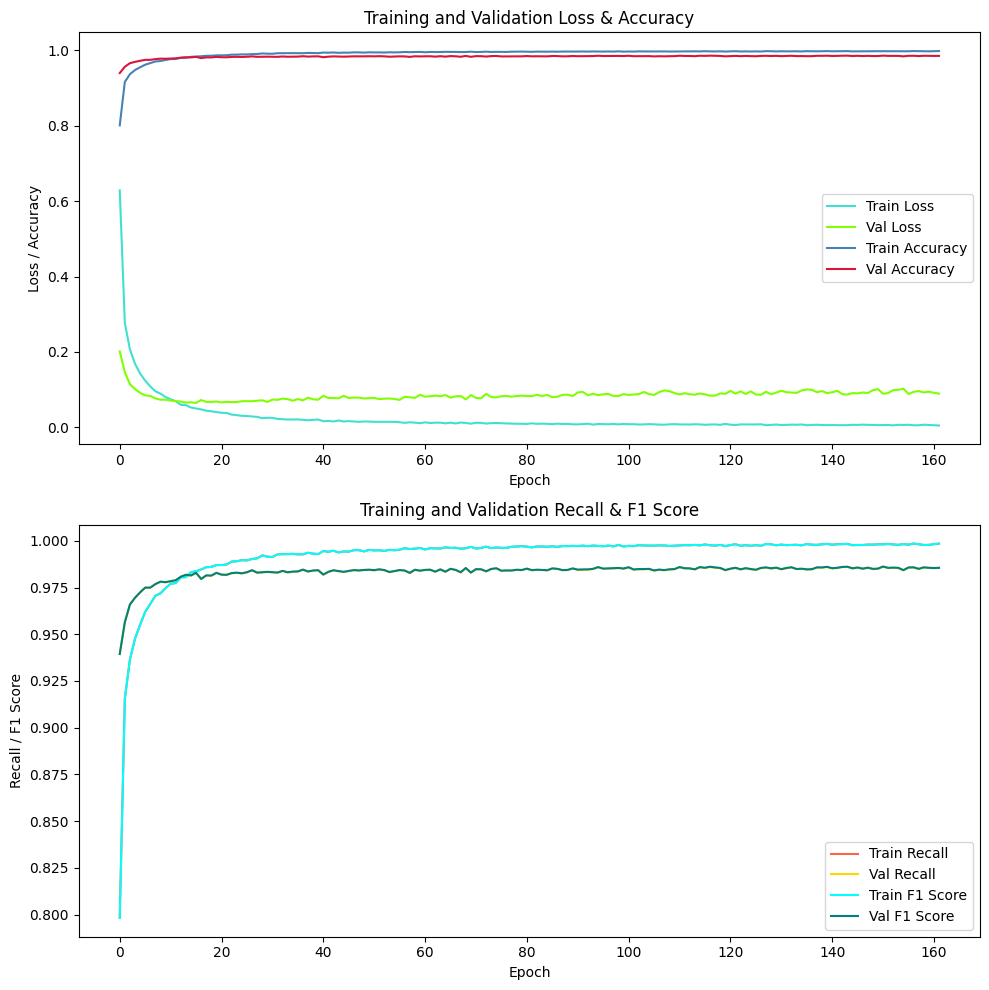

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))

ax1.plot(history['loss'], label='Train Loss', color='turquoise')
ax1.plot(history['val_loss'], label='Val Loss', color='chartreuse')
ax1.plot(history['accuracy'], label='Train Accuracy', color='steelblue')
ax1.plot(history['val_accuracy'], label='Val Accuracy', color='crimson')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss / Accuracy')
ax1.set_title('Training and Validation Loss & Accuracy')
ax1.legend()

ax2.plot(history['recall'], label='Train Recall', color='tomato')
ax2.plot(history['val_recall'], label='Val Recall', color='gold')
ax2.plot(history['f1_score'], label='Train F1 Score', color='cyan')
ax2.plot(history['val_f1_score'], label='Val F1 Score', color='teal')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Recall / F1 Score')
ax2.set_title('Training and Validation Recall & F1 Score')
ax2.legend()

plt.tight_layout()
plt.show()


In [ ]:
model.save('skibidi.pkl')